In [1]:
"""
Calculate stationary Sine-Gordon equation with visocosity
to compare with linear system with discrete dislocation solutions

M*ddu1/dxdx - tm*sin(2pi/b*(u1-u2)) = c*du1/dt
M*ddu2/dxdx + tm*sin(2pi/b*(u1-u2)) = c*du2/dt

"""

'\nCalculate stationary Sine-Gordon equation with visocosity\nto compare with linear system with discrete dislocation solutions\n\nM*ddu1/dxdx - tm*sin(2pi/b*(u1-u2)) = c*du1/dt\nM*ddu2/dxdx + tm*sin(2pi/b*(u1-u2)) = c*du2/dt\n\n'

In [2]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [19]:
# ==========================================
# parameters
L = 100.0            # nm
M = 335.           # Graphene: Et= 335 nN/nm
# tm = 1.0           # Graphene paper: tm = 40kPa = 4.E-5 nN/nm/nm
tm = 0.38           # Graphene potential: tm = 0.38GPa = 0.38 nN/nm/nm
b = 0.141*sqrt(3)  # Graphene: full dislocation d = dCC*sqrt(3)

k = tm*2*pi/b      # nN/nm/nm/nm
c = 10.0            # visicosity
dt = 1.0e-2
theta = 0.5

Lam = sqrt(M/2/k)
F = 0.5*k*b*Lam*(exp(2*L/Lam)+1)/(exp(2*L/Lam)-1)*0.3

print(F)

1.4824165921461898


In [4]:
# ------------------------------------------
# mesh: focus on the normalized version of the equations
Xmin = 0.0
Xmax = +1.0
nel = 1000000
p_order = 2

In [5]:
# ==========================================
# function bank
def dUdX(v):
    return grad(v)[0]

In [6]:
# Class representing the intial conditions
class InitialConditions(UserExpression):
    #def __init__(self):
    #    random.seed(2)
    def eval(self, values, x):
        # values[0] = 0.63 + 0.02*(0.5 - random.random())
        values[0] = 0.0
        values[1] = 0.0
    def value_shape(self):
        return (2,)

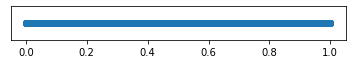

In [7]:
# ==========================================
# mesh
mesh = IntervalMesh(nel, Xmin, Xmax)

plot(mesh)

class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], Xmin, 1.e-14) and on_boundary
class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], Xmax, 1.e-14) and on_boundary

In [8]:
facets = MeshFunction("size_t", mesh, 0)
facets.set_all(0)
Left().mark(facets,1)
Right().mark(facets,2)
ds = Measure("ds", subdomain_data=facets)
n = FacetNormal(mesh)

In [9]:
# =========================================
# function space
V1D = FiniteElement('CG',mesh.ufl_cell(),p_order)
# u1 and u2 for the bot and top layers
V   = FunctionSpace(mesh,MixedElement(V1D,V1D))

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [10]:
# This imposes a Dirichlet condition at the point x=0
def Dirichlet_X0_boundary(x,on_boundary):
    tol = 1e-14
    return abs(x[0]-Xmin)<tol

# This imposes a Dirichlet condition at the point x=1
def Dirichlet_X1_boundary(x,on_boundary):
    tol = 1e-14
    return abs(x[0]-Xmax)<tol

In [11]:
# =========================================
# BCs for the u1-u10 for each step
# --------------------------------------
# half of the system: 
# Enforce u1=0,u2=0 at x=0
#        force condition: du1/dx=-F/M, du2/dx=+F/M at x=L
# in the normalized form:
# U1=U2=0 at X=0
# dU1dX = -F/M*L/b, dU2dX = +F/M*L/b
# ---------------------------------------
bcs = [DirichletBC(V.sub(0), Constant(0),        Dirichlet_X0_boundary),
       DirichletBC(V.sub(1), Constant(0),        Dirichlet_X0_boundary),]

In [12]:
# =========================================
# define functions
# previous solution
Uvec_0 = Function(V)

# current solution
Uvec_1 = Function(V)

# define test functions
Vvec = TestFunction(V)

In [13]:
# Split mixed functions
U1_0, U2_0 = split(Uvec_0)
U1_1, U2_1 = split(Uvec_1)
V1_1, V2_1 = split(Vvec)

In [14]:
# initialize the solution
u_ini = InitialConditions()
Uvec_0.interpolate(u_ini)
Uvec_1.interpolate(u_ini)


In [24]:
# weak form
# theta method
U1_mid = (1.-theta)*U1_0 + theta*U1_1
U2_mid = (1.-theta)*U2_0 + theta*U2_1

# FF = inner(dUdX(U1_1), dUdX(V1_1))*dx + tm/M*L*L/b*sin(2*pi*(U1_1-U2_1))*V1_1*dx \
#      + c*b/M*(U1_1-U1_0)/dt*V1_1*dx \
#      - (-F/M*L/b)*V1_1*ds(2) + \
#      inner(dUdX(U2_1), dUdX(V2_1))*dx - tm/M*L*L/b*sin(2*pi*(U1_1-U2_1))*V2_1*dx \
#      + c*b/M*(U2_1-U2_0)/dt*V2_1*dx \
#      - (+F/M*L/b)*V2_1*ds(2)

# FF = inner(dUdX(U1_mid), dUdX(V1_1))*dx + tm/M*L*L/b*sin(2*pi*(U1_mid-U2_mid))*V1_1*dx \
#      + c*b/M*(U1_1-U1_0)/dt*V1_1*dx \
#      - (-F/M*L/b)*V1_1*ds(2) + \
#      inner(dUdX(U2_mid), dUdX(V2_1))*dx - tm/M*L*L/b*sin(2*pi*(U1_mid-U2_mid))*V2_1*dx \
#      + c*b/M*(U2_1-U2_0)/dt*V2_1*dx \
#      - (+F/M*L/b)*V2_1*ds(2)

FF = inner(dUdX(U1_mid), dUdX(V1_1))*dx + tm/M*L*L/b*sin(2*pi*(U1_0-U2_0))*V1_1*dx \
     + c*b/M*(U1_1-U1_0)/dt*V1_1*dx \
     - (-F/M*L/b)*V1_1*ds(2) + \
     inner(dUdX(U2_mid), dUdX(V2_1))*dx - tm/M*L*L/b*sin(2*pi*(U1_0-U2_0))*V2_1*dx \
     + c*b/M*(U2_1-U2_0)/dt*V2_1*dx \
     - (+F/M*L/b)*V2_1*ds(2)

J = derivative(FF, Uvec_1)
problem = NonlinearVariationalProblem(FF, Uvec_1, bcs, J)
solver  = NonlinearVariationalSolver(problem)

staggered_tol     = 1e-6 # tolerance for the staggered scheme
staggered_maxiter = 10   # max. iteration for the staggered scheme
newton_Rtol       = 1e-8 # relative tolerance for Newton solver (balance eq.)
newton_Atol       = 1e-8 # absoulte tolerance for Newton solver (balance eq.)
newton_maxiter    = 20   # max. iteration for Newton solver (balance eq.)
snes_Rtol         = 1e-9 # relative tolerance for SNES solver (phase field eq.)
snes_Atol         = 1e-9 # absolute tolerance for SNES solver (phase field eq.)
snes_maxiter      = 30   # max. iteration for SNEs solver (phase field eq.)

# Set nonlinear solver parameters
newton_prm = solver.parameters['newton_solver']
newton_prm['relative_tolerance'] = newton_Rtol
newton_prm['absolute_tolerance'] = newton_Atol
newton_prm['maximum_iterations'] = newton_maxiter
newton_prm['error_on_nonconvergence'] = False


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [ ]:
# Step in time
t = 0.0
T = 5*dt
while (t < T):
    t += dt
    Uvec_0.vector()[:] = Uvec_1.vector()
    solver.solve()

(-1, 1)

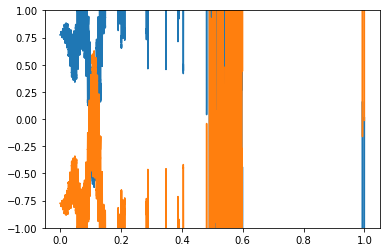

In [23]:
plt.figure()
plot(b/L*dUdX(U1_1))
plot(b/L*dUdX(U2_1))
plt.ylim(-1,1)